<a href="https://colab.research.google.com/github/Xelvise/NLP-compilation-with-HuggingFace/blob/main/Fine_tuning_Pegasus_for_Text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This project entails fine-tuning Pegasus (a transformer model) on a corpus of messenger-like conversations along with human-annotated summaries

- Generating accurate summaries can help improve customer service and detect common patterns among customer requests. Hence, it does have a commercial application

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [ ]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements.

    Generator function to yield successive batch-sized chunks from list_of_elements.

    Parameters:
    list_of_elements (list): List of elements to be divided into chunks.
    batch_size (int): The size of each chunk.

    Yields:
    list: Batch-sized chunk from list_of_elements.

    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_data(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    """
    Function to calculate a specified metric on a test dataset for a Natural Language Processing (NLP) task.
    It assumes the task is a text summarization task, where the goal is to generate a summary from a text.

    Parameters:
    dataset (pandas.DataFrame): The test dataset. It should contain a column for the text and a column for the true summary.
    metric (datasets.Metric): The metric to calculate. This should be a metric object from the Hugging Face datasets library.
    model (transformers.PreTrainedModel): The transformer model to use for text generation.
    tokenizer (transformers.PreTrainedTokenizer): The tokenizer corresponding to the model.
    batch_size (int, optional): The size of the batches to use for processing. Defaults to 16.
    device (str, optional): The device to run the model on. Defaults to the output of torch.cuda.is_available().
    column_text (str, optional): The name of the column in the dataset that contains the text. Defaults to 'article'.
    column_summary (str, optional): The name of the column in the dataset that contains the true summary. Defaults to 'highlights'.

    Returns:
    score (float): The calculated score of the metric on the test dataset.
    """

    # article batches is a list of generated batches from the dialogue dataset
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    # target batches, on the other hand, is a list of generated batches from the dialogue dataset
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    # looping over the both lists of batches, we tokenize each batch of dialogues...
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")

        # The input_ids and attention masks of the tokenized batches of dialogues are fed to pegasus model for summary generation
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts, replace the <n> token,
        # and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

        # HuggingFace metric.add_batch is then used to generate a rogue score by comparing model's generated summaries with the actual summary
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

#### Fine-tuning Pegasus model on a Dialogue dataset from [HuggingFace Samsum](https://huggingface.co/datasets/samsum)

- To make sense of these dialogues - they could represent the chat-conversation between a customer and the support center. So generating accurate summaries can help improve customer service and detect common patterns among customer needs

In [ ]:
dataset_samsum = load_dataset("samsum")
dataset_samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


#### First, we begin by evaluating Pegasus BaseModel on Samsum dataset

In [ ]:
pipe = pipeline('summarization', model=model_ckpt)
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])

In [ ]:
# model_pegasus

In [ ]:
print(pipe_out)

In [ ]:
#  Calculate rogue scores

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')     # initialize Hugginface rouge metric

score = calculate_metric_on_test_data(
    dataset_samsum['test'],
    rouge_metric,
    model_pegasus,
    tokenizer,
    column_text='dialogue',
    column_summary='summary',
    batch_size=8
)

# Here, we loop through all the rouge names, take the mid.fmeasure and populate a dictionary out of it

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index = ['pegasus'])

- It appears the rogue (i.e,evaluation) score is quite low, as expected.
- This is because the base Pegasus model isn't typicaly trained on this very samsum dataset, hence the reason for Fine-tuning

### Plot a Histogram showing length of dialogues against summaries.
This is necessary to find out the average token length for dialogues and summaries, along with the range of token length where the maximum occurences are happening for both the dialogues and their summaries

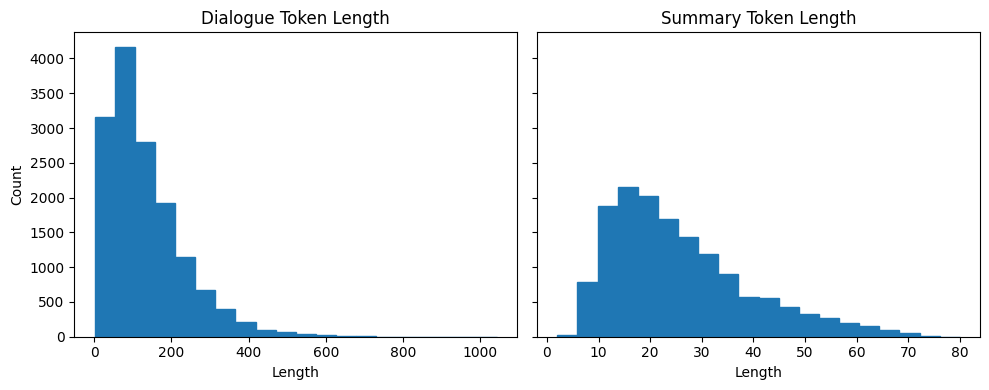

In [ ]:
dialogue_token_len = list(len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue'])
summary_token_len = list(len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='row')
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0')
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

- From the histogram above, it can be seen that most dialogues are relatively shorter, so are summaries.
Hence, when defining training config, dialogue token length can have a max length of about 1024, while the summary have 128.

- Now, we'd define a function for converting each example sequence to features. The function is meant to return the input_ids, attention_masks and labels as a dict

In [ ]:
def tokenize_sequences(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length=128, truncation=True)

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(tokenize_sequences, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

The context manager `tokenizer.as_target_tokenizer()` temporarily sets the tokenizer for encoding the targets. It is particularly useful for tokenizers associated with seq-to-seq models that needs a slightly different processing for the labels.

The `.as_target_tokenizer` method is specifically for seq-to-seq models in order to separate between the source and target tokenizers. It's not needed for other models that aren't seq-to-seq.

Next, we utilize DataCollatorForSeq2Seq in order to form a batch by using a list of dataset elements as input. These elements are of the same type as elemnts of train or eval dataset.

And in order to be ready to build batches, this data collator info classifier may apply some preocessing such as padding or random data enhancements on formed batches.

In [ ]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

N.B: Since this model is quite large in size, we had to set both the per_device_train_batch_size and per_device_test_batch_size to 1.

However, such a little batch size can hurt convergence. To resolve this issue, we use a nifty technique called gradient_accumulation_step.

So as the name suggests, instead of calculating the gradients of the full batch all at once, we mix smaller batches and aggregate the gradients.
When we have aggregated enough gradients, we run the optimisation step. Naturally, this is a bit slower than doing it in one pass but it does save you lots of GPU memory

In [ ]:
trainer = Trainer(
    model=model_pegasus,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"]
)

trainer.train()

model.save_pretrained('/saved_models')        # save locally
tokenizer.save_pretrained('/saved_models')

In [ ]:
# visualize fine-tuned model architecture
trainer.model

In [ ]:
#  Calculate rogue scores

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')     # initialize Hugginface rouge metric

score = calculate_metric_on_test_data(
    dataset_samsum['test'],
    rouge_metric,
    trainer.model,
    tokenizer,
    column_text='dialogue',
    column_summary='summary',
    batch_size=2
)

# Here, we loop through all the rouge names, take the mid.fmeasure and populate a dictionary out of it

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

### Now, we proceed to run inference on our Fine-tuned model on the test dataset

In [ ]:
print(dataset_samsum["test"]["dialogue"][0])

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye


In [ ]:
print(dataset_samsum["test"]["summary"][0])

Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained('/saved_models')

# set hyper-parameters for the fine-tuned model
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

# select the first example dialogue in the test set
sample_text = dataset_samsum["test"][0]["dialogue"]
# select the first example summary in the test set
reference = dataset_samsum["test"][0]["summary"]

pipe = pipeline("summarization", model=finetuned_model, tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])